## Energy consumption, fuel use and emissions
In this notebook, we set up a basic simulation where a vessel moves over a 1D netork path. We add some properties to the graph (depth, width) and the vessel (VesselProperties, ConsumesEnergy) in order to calculate resistance, required power, and emissions.
OpenTNSim model run. 

We take the following steps:

1. [Imports](#1.-Imports)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [1]:
# package(s) used for creating and geo-locating the graph
import networkx as nx  
import shapely.geometry
import pyproj
import warnings

# package(s) related to the simulation (creating the vessel, running the simulation)
import datetime, time
import simpy
import opentnsim

# package(s) needed for data handling and inspecting the output
import numpy as np
import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

import logging
#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages

from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


print('This notebook is executed with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook is executed with OpenTNSim version 1.1.2


### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _Movable_ - allows the vessel to move, with a fixed speed, while logging this activity,
   * Movable in turn relies on the mix-ins: _Locatable_, _Routeable_, and _Log_
* _VesselProperties_ - allows to give the vessel specific properties, 
* _ConsumesEnergy_ - enables calculation of resistance, required power and emissions

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later
# Note that we set "h_squat" as "True". 
# The squat effect makes a great difference for the actual water depth and resistance calculation in shallow water. 
# Here we need to calculate the water depth reduced by squat since what we give the ship is a route with undisturbed water depth h_0.

data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":None,
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": 3.5,      # <=== here we should enter the value from the T strategy notebook
               "safety_margin": 0.2, # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
               "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False
               "P_installed": 1750.0,
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }             

vessel = TransportResource(**data_vessel)

### 2. Create graph
Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the python package networkx to do this. 

For this example, we construct a network of 4 nodes linked by 3 edges. The edges are made bi-directional to allow for two-way traffic, which means that the graph in the end contains 6 edges.

In [4]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.8983,0], 
    [1.7966,0], 
    [2.6949,0]] 

# for each edge (between above coordinates) specify the depth (m)
depths = [6, 4.5, 6]

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [5]:
# create a graph 
FG = nx.DiGraph()
nodes = []
path = []

# make your preferred Site class out of available mix-ins.
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

# add nodes
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": depths[index]})

In [6]:
# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [7]:
# create a positions dict for the purpose of plotting
positions = {}
for node in FG.nodes:
    positions[node] = (FG.nodes[node]['geometry'].x, FG.nodes[node]['geometry'].y)

In [8]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

Number of nodes is 4:
Number of edges is 6:


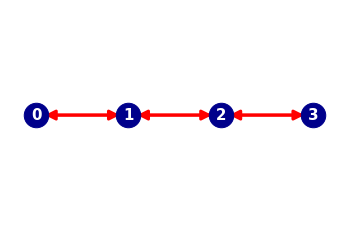

In [9]:
print('Number of nodes is {}:'.format(len(FG.nodes)))
print('Number of edges is {}:'.format(len(FG.edges)))

# draw edges, nodes and labels.
nx.draw_networkx_edges(FG,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=20)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=600)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=15, font_weight='bold', font_color="white")

plt.axis("off")
plt.show()

In [10]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('0', '1') is 6
General depth for edge ('1', '0') is 6
General depth for edge ('1', '2') is 4.5
General depth for edge ('2', '1') is 4.5
General depth for edge ('2', '3') is 6
General depth for edge ('3', '2') is 6


### 4. Run simulation
Now we can define the run. After we define the path that the vessel will sail, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [11]:
# create a path along that the vessel needs to follow (in this case from the first node to the last node)
path = nx.dijkstra_path(FG, nodes[0].name, nodes[3].name)

### Run simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [12]:
def run_simulation(V_s, P_tot_given):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel.P_tot_given = P_tot_given
              
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

In [13]:
input_data = {'V_s': [3.0, 3.5, 4.0, None, None, None], 'P_tot_given': [None, None, None, 333, 473, 707]}
input_data

{'V_s': [3.0, 3.5, 4.0, None, None, None],
 'P_tot_given': [None, None, None, 333, 473, 707]}

In [14]:
# create empty plot data
plot_data = {}

# loop through the various input data
for index, value in enumerate(input_data['V_s']):
    
    # Run a basic simulation with V_s and P_tot_given combi
    vessel = run_simulation(input_data['V_s'][index], input_data['P_tot_given'][index])
    
    # create an EnergyCalculation object and perform energy consumption calculation
    
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    
    energycalculation.calculate_energy_consumption()
    
    # create dataframe from energy calculation computation
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    # add/modify some comlums to suit our plotting needs
   
    df['fuel_kg_per_km'] = (df['total_fuel_consumption']/1000) / (df['distance']/1000)
    df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
    df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
    df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)
    
    label = 'V_s = ' + str(input_data['V_s'][index]) + ' P_tot_given = ' + str(input_data['P_tot_given'][index])

    # Note that we make a dict to collect all plot data. 
    # We use labels like ['V_s = None P_tot_given = 274 fuel_kg_km'] to organise the data in the dict
    # The [0, 0, 1, 1, 2, 2] below creates a list per section 
    plot_data[label + ' v'] = list(df.distance[[0, 0, 1, 1, 2, 2]]/df.delta_t[[0, 0, 1, 1, 2, 2]])
    plot_data[label + ' P_tot']   = list(df.P_tot[[0, 0, 1, 1, 2, 2]])
    plot_data[label + ' fuel_kg_per_km']   = list(df.fuel_kg_per_km[[0, 0, 1, 1, 2, 2]])
    plot_data[label + ' CO2_g_per_km'] = list(df.CO2_g_per_km[[0, 0, 1, 1, 2, 2]])
    plot_data[label + ' PM10_g_per_km']   = list(df.PM10_g_per_km[[0, 0, 1, 1, 2, 2]])
    plot_data[label + ' NOx_g_per_km']   = list(df.NOx_g_per_km[[0, 0, 1, 1, 2, 2]])
        

### 5. Inspect output
We can now analyse the simulation output by inspecting the vessel.log. Note that the _Log_ mix-in was included when we added _Movable_. The vessel.log keeps track of the moving activities of the vessel. For each discrete event OpenTNSim logs an event message, the start/stop time and the location. The vessel.log is of type dict. For convenient inspection it can be loaded into a Pandas dataframe. 

In [15]:
# this is now in the plot data
plot_data

{'V_s = 3.0 P_tot_given = None v': [3.000000000017929,
  3.000000000017929,
  3.000000000017929,
  3.000000000017929,
  3.00000000001793,
  3.00000000001793],
 'V_s = 3.0 P_tot_given = None P_tot': [332.88038636237764,
  332.88038636237764,
  350.6277405387947,
  350.6277405387947,
  332.88038636237786,
  332.88038636237786],
 'V_s = 3.0 P_tot_given = None fuel_kg_per_km': [7.837832301403711,
  7.837832301403711,
  8.21275465803749,
  8.21275465803749,
  7.837832301403714,
  7.837832301403714],
 'V_s = 3.0 P_tot_given = None CO2_g_per_km': [24867.30430172632,
  24867.30430172632,
  26056.830687773498,
  26056.830687773498,
  24867.304301726326,
  24867.304301726326],
 'V_s = 3.0 P_tot_given = None PM10_g_per_km': [14.984978665836875,
  14.984978665836875,
  15.4470714311579,
  15.4470714311579,
  14.984978665836879,
  14.984978665836879],
 'V_s = 3.0 P_tot_given = None NOx_g_per_km': [346.69882073780866,
  346.69882073780866,
  360.5979582619547,
  360.5979582619547,
  346.698820737808

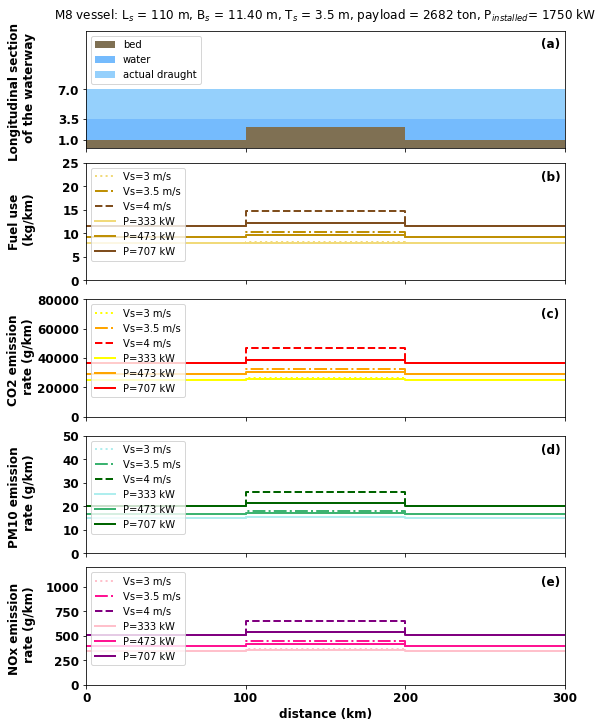

In [16]:
fig, axs = plt.subplots(5, 1, figsize=(8, 10), sharex=True,constrained_layout=True)
fontsize=12

ax=plt.subplot(511)    # Longitudinal section of the waterway
plt.title('M8 vessel: L$_s$ = 110 m, B$_s$ = 11.40 m, T$_s$ = 3.5 m, payload = 2682 ton, P$_{installed}$= 1750 kW',y=1.05)
# these values you probably want to extract from the graph, or from the log (minimise the manual work!!)
dist=[0,100,100,200,200,300]
water_level=[2.5,2.5,1,1,2.5,2.5,]
bed_level=[1,1,2.5,2.5,1,1]
draft=[3.5,3.5,3.5,3.5,3.5,3.5,]

plt.stackplot(dist,bed_level,water_level,draft, labels=['bed','water','actual draught'],colors=['#7f7053','#75bbfd','#95d0fc'])
plt.ylabel('Longitudinal section \n of the waterway',fontsize=12,fontweight='bold',labelpad=22)
plt.xlim(0, 300)
plt.ylim(0, 14)
plt.xticks( weight = 'bold')
plt.yticks([1,3.5,7], weight = 'bold', fontsize=12)
ax.legend(loc='upper left')
ax.text(285, 12, '(a)', fontsize=12,weight = 'bold')

ax=plt.subplot(512)    #  fuel (diesel) consumption kg/km 

diesel_fv1=(plot_data['V_s = 3.0 P_tot_given = None fuel_kg_per_km']) # use values from the output_plot variable
diesel_fv2=(plot_data['V_s = 3.5 P_tot_given = None fuel_kg_per_km'])
diesel_fv3=(plot_data['V_s = 4.0 P_tot_given = None fuel_kg_per_km'])
diesel_fp1=(plot_data['V_s = None P_tot_given = 333 fuel_kg_per_km'])
diesel_fp2=(plot_data['V_s = None P_tot_given = 473 fuel_kg_per_km'])
diesel_fp3=(plot_data['V_s = None P_tot_given = 707 fuel_kg_per_km'])

plt.plot(dist, diesel_fv1,':',color='#f1da7a',linewidth='2',label='Vs=3 m/s')
plt.plot(dist, diesel_fv2,'-.',color='#bf9005',linewidth='2',label='Vs=3.5 m/s')
plt.plot(dist, diesel_fv3,'--',color='#7f4e1e',linewidth='2',label='Vs=4 m/s')
plt.plot(dist, diesel_fp1,color='#f1da7a',linewidth='2',label='P=333 kW')
plt.plot(dist, diesel_fp2,color='#bf9005',linewidth='2',label='P=473 kW')
plt.plot(dist, diesel_fp3,color='#7f4e1e',linewidth='2',label='P=707 kW')
plt.ylabel('Fuel use\n (kg/km)',fontsize=12,fontweight='bold',labelpad=26)
plt.ylim(0, 25)
plt.xlim(0, 300)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
ax.legend(loc='upper left')
ax.text(285, 25*11/13, '(b)', fontsize=12,weight = 'bold')

ax=plt.subplot(513)    #  CO2 emission rates g/km
ax.legend(loc='upper left')

EMrCO2_fv1=(plot_data['V_s = 3.0 P_tot_given = None CO2_g_per_km'])
EMrCO2_fv2=(plot_data['V_s = 3.5 P_tot_given = None CO2_g_per_km'])
EMrCO2_fv3=(plot_data['V_s = 4.0 P_tot_given = None CO2_g_per_km'])
EMrCO2_fp1=(plot_data['V_s = None P_tot_given = 333 CO2_g_per_km'])
EMrCO2_fp2=(plot_data['V_s = None P_tot_given = 473 CO2_g_per_km'])
EMrCO2_fp3=(plot_data['V_s = None P_tot_given = 707 CO2_g_per_km'])

plt.plot(dist, EMrCO2_fv1,':',color='yellow',linewidth='2',label='Vs=3 m/s')
plt.plot(dist, EMrCO2_fv2,'-.',color='orange',linewidth='2',label='Vs=3.5 m/s')
plt.plot(dist, EMrCO2_fv3,'--',color='red',linewidth='2',label='Vs=4 m/s')
plt.plot(dist, EMrCO2_fp1,color='yellow',linewidth='2',label='P=333 kW')
plt.plot(dist, EMrCO2_fp2,color='orange',linewidth='2',label='P=473 kW')
plt.plot(dist, EMrCO2_fp3,color='red',linewidth='2',label='P=707 kW')
ax.legend(loc='upper left')
plt.ylabel('CO2 emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=2)
plt.ylim(0, 80000)
plt.xlim(0, 300)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
ax.text(285, 80000*11/13, '(c)', fontsize=12,weight = 'bold')

ax=plt.subplot(514)    #  PM10 emission rates g/km

EMrPM10_fv1=(plot_data['V_s = 3.0 P_tot_given = None PM10_g_per_km'])
EMrPM10_fv2=(plot_data['V_s = 3.5 P_tot_given = None PM10_g_per_km'])
EMrPM10_fv3=(plot_data['V_s = 4.0 P_tot_given = None PM10_g_per_km'])
EMrPM10_fp1=(plot_data['V_s = None P_tot_given = 333 PM10_g_per_km'])
EMrPM10_fp2=(plot_data['V_s = None P_tot_given = 473 PM10_g_per_km'])
EMrPM10_fp3=(plot_data['V_s = None P_tot_given = 707 PM10_g_per_km'])

plt.plot(dist, EMrPM10_fv1,':',color='paleturquoise',linewidth='2',label='Vs=3 m/s')
plt.plot(dist, EMrPM10_fv2,'-.',color='mediumseagreen',linewidth='2',label='Vs=3.5 m/s')
plt.plot(dist, EMrPM10_fv3,'--',color='darkgreen',linewidth='2',label='Vs=4 m/s')
plt.plot(dist, EMrPM10_fp1,color='paleturquoise',linewidth='2',label='P=333 kW')
plt.plot(dist, EMrPM10_fp2,color='mediumseagreen',linewidth='2',label='P=473 kW')
plt.plot(dist, EMrPM10_fp3,color='darkgreen',linewidth='2',label='P=707 kW')
ax.legend(loc='upper left')
plt.ylabel('PM10 emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=26)
plt.ylim(0, 50)
plt.xlim(0, 300)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold', fontsize=12)
ax.text(285, 50*11/13, '(d)', fontsize=12,weight = 'bold')

ax=plt.subplot(515)     #  NOx emission rates g/km

EMrNOx_fv1=(plot_data['V_s = 3.0 P_tot_given = None NOx_g_per_km'])
EMrNOx_fv2=(plot_data['V_s = 3.5 P_tot_given = None NOx_g_per_km'])
EMrNOx_fv3=(plot_data['V_s = 4.0 P_tot_given = None NOx_g_per_km'])
EMrNOx_fp1=(plot_data['V_s = None P_tot_given = 333 NOx_g_per_km'])
EMrNOx_fp2=(plot_data['V_s = None P_tot_given = 473 NOx_g_per_km'])
EMrNOx_fp3=(plot_data['V_s = None P_tot_given = 707 NOx_g_per_km'])

plt.plot(dist, EMrNOx_fv1,':',color='pink',linewidth='2',label='Vs=3 m/s')
plt.plot(dist, EMrNOx_fv2,'-.',color='deeppink',linewidth='2',label='Vs=3.5 m/s')
plt.plot(dist, EMrNOx_fv3,'--',color='purple',linewidth='2',label='Vs=4 m/s')
plt.plot(dist, EMrNOx_fp1,color='pink',linewidth='2',label='P=333 kW')
plt.plot(dist, EMrNOx_fp2,color='deeppink',linewidth='2',label='P=473 kW')
plt.plot(dist, EMrNOx_fp3,color='purple',linewidth='2',label='P=707 kW')
plt.ylabel('NOx emission \n rate (g/km)',fontsize=12,fontweight='bold',labelpad=10)
plt.xlabel('distance (km)',fontsize=12,fontweight='bold',labelpad=3)
plt.ylim(0, 1200)
plt.xlim(0, 300)
ax.legend(loc='upper left')
plt.xticks([0,100,200,300], weight = 'bold', fontsize=12)
plt.yticks( weight = 'bold', fontsize=12)
ax.text(285, 1200*11/13, '(e)', fontsize=12,weight = 'bold')

plt.savefig('Fig_11.pdf',bbox_inches = 'tight', dpi=600, format='pdf')  